In [10]:
import urllib.request
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import os
import math

In [104]:
def get_tiles(url):
    urllib.request.urlretrieve(url,"tile.png")
    tile = np.asarray(Image.open("tile.png"))

    return tile

def get_flood_tiles(x,y,z,e):
    """ 
    :params x,y,z: x and y tiles, z=zoom level
    :param e (f)
    """
    url_flood = f'https://www.floodmap.net/getFMTile.ashx?x={x}&y={y}&z={z}&e={e}'
    return get_tiles(url_flood)

def get_pop_2020_tiles(merc_coord):
    return f'https://sedac.ciesin.columbia.edu/geoserver/wms?service=WMS&request=GetMap&layers=gpw-v4%3Agpw-v4-population-density_2020%2Ccartographic%3A00-global-labels&styles=&format=image%2Fpng&transparent=true&version=1.1.1&width=256&height=256&srs=EPSG%3A3857&bbox={merc_coord[0][1]},{merc_coord[1][0]},{merc_coord[1][1]},{merc_coord[0][0]}'

def get_ssp_tiles(ssp_name,merc_coord):
    return f'https://sedac.ciesin.columbia.edu/geoserver/wms?service=WMS&request=GetMap&layers=popdynamics%3Apopdynamics-pop-projection-ssp-2010-2100_{ssp_name}-total-population%2Ccartographic%3A00-global-labels&styles=&format=image%2Fpng&transparent=true&version=1.1.1&height=256&width=256&srs=EPSG%3A3857&bbox={merc_coord[0][1]},{merc_coord[1][0]},{merc_coord[1][1]},{merc_coord[0][0]}'

def get_image(fp):
    return np.asarray(Image.open(fp))

def tile_num_to_lat_lon(xtile,ytile, zoom):
    """
    :param xtile (int): corresponds to google slippy map tile number
    :param ytile (int): corresponds to google slippy map tile number
    returns the coordinate of the upper left (northwest most) point of the tile,
    and the coordinate of the lower right (south east most) point of tile
    in WGS84 datum
    """
    def num2deg(xtile, ytile, zoom):
      n = 1 << zoom #2**zoom
      lon_deg = xtile / n * 360.0 - 180.0
      lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
      lat_deg = math.degrees(lat_rad)
      return lat_deg, lon_deg
    
    UL = num2deg(xtile, ytile, zoom)
    LR = num2deg(xtile+1, ytile+1, zoom)
    return UL,LR

def lat_lon_to_mercator(coord, R =  6378137.0):
    """ 
    :param coord (tuple): where coord = (UL,LR), 
        UL = (lat_deg, lon_deg) of upper left corner of tile
        LR = (lat_deg, lon_deg) of lower right corner of tile
    """
    def lat2y(lat, R=R):
        return math.log(math.tan(math.pi / 4 + math.radians(lat) / 2)) * R

    def lon2x(lon, R=R):
        return math.radians(lon) * R
    
    UL_wgs = coord[0]
    LR_wgs = coord[1]
    UL_merc = (lat2y(UL_wgs[0]),lon2x(UL_wgs[1]))
    LR_merc = (lat2y(LR_wgs[0]),lon2x(LR_wgs[1]))
    return UL_merc, LR_merc

def save_tiles(tile_list,save_dir,ssp_name=None):
    """ 
    :param tile_list (list of tuples): where each tuple is (x,y,z), where z is the zoom level
    :param ssp_name (str): name of ssp e.g. ssp1-2050
    """
    if ssp_name is None:
        ssp_name = 'population-density_2020'
    ssp_dir = os.path.join(save_dir,ssp_name)
    if not os.path.exists(ssp_dir):
        os.mkdir(ssp_dir)
    for (x,y,z) in tile_list:
        coord = tile_num_to_lat_lon(x,y,z)
        merc_coord = lat_lon_to_mercator(coord)
        if ssp_name == 'population-density_2020':
            url = get_pop_2020_tiles(merc_coord)
        else:
            url = get_ssp_tiles(ssp_name,merc_coord)
        
        tile = get_tiles(url)
        tilename = os.path.join(ssp_dir,f'x-{x}_y-{y}_z-{z}.png')
        print(tilename)
        im = Image.fromarray(tile)
        im.save(tilename)

    return

class FloodSSP:
    def __init__(self, e, ssp_dir, ssp_legend_dict_fp):
        """ 
        :param e (int): elevation of SLR
        :param ssp_dir (str): directory of ssp
        :param
        """
        self.e = e
        self.ssp_dir = ssp_dir
        self.ssp_name = os.path.basename(ssp_dir)
        self.ssp_legend_dict_fp = ssp_legend_dict_fp
        self.legend_dict = None
        if os.path.exists(ssp_legend_dict_fp):
            with open(ssp_legend_dict_fp,'rb') as f:
                legend_dict = pickle.load(f)
            self.legend_dict = legend_dict
            self.legend_dict_px_arr = np.vstack([self.legend_dict[i]['pixel_val'] for i in range(len(self.legend_dict))])
            self.min_popn_legend = np.array([self.legend_dict[i]['min'] for i in range(len(self.legend_dict))]) # min popn count for legend 0 to 11
            self.max_popn_legend = np.array([self.legend_dict[i]['max'] for i in range(len(self.legend_dict))]) # max popn count for legend 0 to 11
            self.legend_dict_px_arr_norm = self.legend_dict_px_arr/np.tile(np.linalg.norm(self.legend_dict_px_arr,axis=1).reshape(-1,1),(1,3))
        else:
            raise IOError
        self.flood_dir = os.path.join(os.path.dirname(ssp_dir),f'flood_{int(e)}')
        self.save_dir = os.path.join(os.path.dirname(ssp_dir),f'{self.ssp_name}_e-{e}')
        

    def get_xyz(self,fn):
        """ 
        :param fn (str): get xyz from filename
        """
        xyz = os.path.splitext(fn)[0]
        x,y,z = [int(i[-1]) for i in xyz.split('_')]
        return x,y,z
    
    def popn_affected(self,save_dir=False):
        """ 
        :param save_dir (bool)
        """
        if not os.path.exists(self.save_dir) and save_dir is True:
            os.mkdir(self.save_dir)
        popn_min = []
        popn_max = []
        for img_fp in os.listdir(self.ssp_dir):
            xyz = os.path.splitext(img_fp)[0]
            x,y,z = [int(i[-1]) for i in xyz.split('_')]
            ssp_fp = os.path.join(self.ssp_dir,img_fp)
            ssp_img = get_image(ssp_fp)
            if os.path.exists(self.flood_dir):
                flood_fp = os.path.join(self.flood_dir,img_fp)
                flood_img = get_image(flood_fp)
            else:
                flood_img = get_flood_tiles(x,y,z,self.e)
            if save_dir is True:
                save_fp = os.path.join(self.save_dir,f'x-{x}_y-{y}_z-{z}.png')
            else:
                save_fp = None
            flooded_extent = self.get_flooded_extent(flood_img,ssp_img,save_fp=save_fp)
            popn = self.calculate_popn_affected(flooded_extent)
            if popn is not None:
                popn_min.append(popn[0])
                popn_max.append(popn[1])
            
        if len(popn_min) > 0:
            return sum(popn_min), sum(popn_max)
        else:
            return None

    def get_flooded_extent(self,flood_img,ssp_img,save_fp=None):
        """ 
        :param save_fp (str)
        """
        assert flood_img.shape[-1] == 4 and ssp_img.shape[-1] == 4 #check that its img with alpha channel
        mask_list = [flood_img[:,:,-1],ssp_img[:,:,-1]]
        mask_list = [(m/255).astype(np.uint8) for m in mask_list]
        flooded_extent_mask = np.multiply(*mask_list)
        flooded_extent_mask = np.repeat(flooded_extent_mask[:,:,np.newaxis],4,axis=2)
        # print(flooded_extent_mask.shape)
        flooded_extent = flooded_extent_mask*ssp_img#[:,:,:3]
        if save_fp is not None:
            im = Image.fromarray(flooded_extent)
            im.save(save_fp)
        return flooded_extent

    def calculate_popn_affected(self,flooded_extent):
        """ 
        :param legend_dict (dict): maps pixel values to popn
        returns estimated min and max population affected
        """
        # use dot matrix to quickly calculate which color palette has the highest dot product value instead of using for loops
        if self.legend_dict is not None:
            flooded_extent = flooded_extent[:,:,:3]
            px_arr, counts = np.unique(flooded_extent.reshape(-1, flooded_extent.shape[2]), axis=0,return_counts=True)
            
            px_arr_norm = px_arr/np.tile(np.linalg.norm(px_arr,axis=1).reshape(-1,1),(1,3))
            if np.sum(px_arr[1,:]) == 0:
                px_arr_norm = px_arr_norm[1:,:] # remove the first row because row 0 is [0,0,0] --> normalisation will lead to NAs
                counts = counts[1:]
            dot_pdt = np.dot(px_arr_norm,self.legend_dict_px_arr_norm.T)
            legend_match = np.argmax(dot_pdt,axis=1) #to see which color palette best matches legend color

            legend_count = np.bincount(legend_match,weights = counts) # frequency of pixels for each legend, outputs the length == max(legend_match), e.g. if 9th legend is the highest, length == 10
            # legend_count outputs the pixel count for each legend
            n_legend_detected = legend_count.shape[0]
            # multiply legend_count by popn count as each legend corresponds to a different population count
            min_popn = np.sum(legend_count * self.min_popn_legend[:n_legend_detected])
            max_popn = np.sum(legend_count * self.max_popn_legend[:n_legend_detected])
            return min_popn, max_popn
        else:
            return None

In [107]:
fssp = FloodSSP(e=1, ssp_dir=r'data\tiles\ssp5-2100', ssp_legend_dict_fp=r'data\ssp\ssp5-2100.ob')
fssp.popn_affected(save_dir=True)

C:\Users\PAKHUIYING\AppData\Local\Temp\ipykernel_2492\1526777246.py:180: RuntimeWarning: invalid value encountered in divide
  px_arr_norm = px_arr/np.tile(np.linalg.norm(px_arr,axis=1).reshape(-1,1),(1,3))


(51411621.0, 101534827.0)

In [113]:
ssp5_2100 = {"x-0_y-1_z-3":"https://live.staticflickr.com/65535/53028209306_2a19e504e5_o.png",
"x-0_y-2_z-3":"https://live.staticflickr.com/65535/53028598055_46d5fc26be_o.png",
"x-0_y-3_z-3":"https://live.staticflickr.com/65535/53028383054_81d4eb4c40_o.png",
"x-1_y-1_z-3":"https://live.staticflickr.com/65535/53028383019_da4a4172da_o.png",
"x-1_y-2_z-3":"https://live.staticflickr.com/65535/53028209286_8891e2632b_o.png",
"x-1_y-3_z-3":"https://live.staticflickr.com/65535/53028209276_a238ea3c10_o.png",
"x-2_y-1_z-3":"https://live.staticflickr.com/65535/53027625147_c84b5d1e55_o.png",
"x-2_y-2_z-3":"https://live.staticflickr.com/65535/53027625142_25c22fdffe_o.png",
"x-2_y-3_z-3":"https://live.staticflickr.com/65535/53028598020_922dc30c3f_o.png",
"x-2_y-4_z-3":"https://live.staticflickr.com/65535/53027625132_31092abb6f_o.png",
"x-2_y-5_z-3":"https://live.staticflickr.com/65535/53028209281_0cb3e182fb_o.png",
"x-3_y-1_z-3":"https://live.staticflickr.com/65535/53028382984_243d97fa3a_o.png",
"x-3_y-2_z-3":"https://live.staticflickr.com/65535/53028382989_bc54d17bfa_o.png",
"x-3_y-3_z-3":"https://live.staticflickr.com/65535/53028695588_a83325726c_o.png",
"x-3_y-4_z-3":"https://live.staticflickr.com/65535/53028597935_6d37e9afd7_o.png",
"x-4_y-1_z-3":"https://live.staticflickr.com/65535/53028209216_a0b4f2e581_o.png",
"x-4_y-2_z-3":"https://live.staticflickr.com/65535/53028597925_cb2eea632b_o.png",
"x-4_y-3_z-3":"https://live.staticflickr.com/65535/53028209146_7e540c5111_o.png",
"x-4_y-4_z-3":"https://live.staticflickr.com/65535/53028209131_057e88f49b_o.png",
"x-5_y-1_z-3":"https://live.staticflickr.com/65535/53028597885_e5083cbf07_o.png",
"x-5_y-2_z-3":"https://live.staticflickr.com/65535/53028209136_83e8b9d39a_o.png",
"x-5_y-3_z-3":"https://live.staticflickr.com/65535/53028695528_f43846c42d_o.png",
"x-5_y-4_z-3":"https://live.staticflickr.com/65535/53027625082_20dc53c3d1_o.png",
"x-6_y-1_z-3":"https://live.staticflickr.com/65535/53028382939_2f14ab785d_o.png",
"x-6_y-2_z-3":"https://live.staticflickr.com/65535/53027625032_f15eb1e7d0_o.png",
"x-6_y-3_z-3":"https://live.staticflickr.com/65535/53028382889_7e6b69bd8d_o.png",
"x-6_y-4_z-3":"https://live.staticflickr.com/65535/53028597850_126701364d_o.png",
"x-7_y-1_z-3":"https://live.staticflickr.com/65535/53028597840_7028956860_o.png",
"x-7_y-2_z-3":"https://live.staticflickr.com/65535/53028382874_8bbab93587_o.png",
"x-7_y-3_z-3":"https://live.staticflickr.com/65535/53028597820_d045b0610b_o.png",
"x-7_y-4_z-3":"https://live.staticflickr.com/65535/53028695453_3bf4b5837c_o.png",
"x-7_y-5_z-3":"https://live.staticflickr.com/65535/53028209066_a9d3bac04c_o.png",
}

global_vulnerability_map = dict()
for xyz in list(ssp5_2100):
    x,y,z = [int(i[-1]) for i in xyz.split('_')]
    UL,LR = tile_num_to_lat_lon(x,y,z)
    global_vulnerability_map[xyz] = {"url": ssp5_2100[xyz], "UL": list(UL), "LR": list(LR)}

with open('data/ssp5-2100_e-1.json',"w") as f:
    json.dump(global_vulnerability_map,f,indent=2)

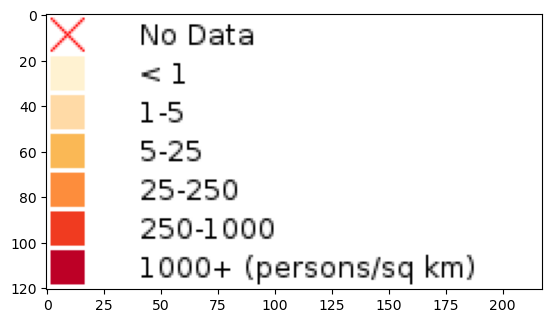

In [56]:
popn_2020_legend = get_tiles('https://sedac.ciesin.columbia.edu/geoserver/ows?service=WMS&request=GetLegendGraphic&format=image/png&width=15&height=15&layer=gpw-v4:gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals_2020&style=gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals_2020:default&')
plt.imshow(popn_2020_legend)

In [58]:
with open('data/mumbai_tiles/mumbai_tiles.ob','rb') as f:
    mumbai_tiles = pickle.load(f)
mumbai_tiles

[(1438, 913, 11),
 (1438, 914, 11),
 (1439, 913, 11),
 (1438, 912, 11),
 (1439, 912, 11)]

In [105]:
with open(r'data\tiles\global_tiles.ob','rb') as f:
    global_tiles = pickle.load(f)
global_tiles

[(2, 5, 3),
 (7, 5, 3),
 (2, 4, 3),
 (3, 4, 3),
 (4, 4, 3),
 (5, 4, 3),
 (6, 4, 3),
 (7, 4, 3),
 (0, 1, 3),
 (0, 2, 3),
 (0, 3, 3),
 (1, 1, 3),
 (1, 2, 3),
 (1, 3, 3),
 (2, 1, 3),
 (2, 2, 3),
 (2, 3, 3),
 (3, 1, 3),
 (3, 2, 3),
 (3, 3, 3),
 (4, 1, 3),
 (4, 2, 3),
 (4, 3, 3),
 (5, 1, 3),
 (5, 2, 3),
 (5, 3, 3),
 (6, 1, 3),
 (6, 2, 3),
 (6, 3, 3),
 (7, 1, 3),
 (7, 2, 3),
 (7, 3, 3)]

In [106]:
for (x,y,z) in global_tiles:
    flood_img = get_flood_tiles(x,y,z,e=1)
    save_fp = os.path.join(r'data\tiles\flood_1',f'x-{x}_y-{y}_z-{z}.png')
    im = Image.fromarray(flood_img)
    im.save(save_fp)

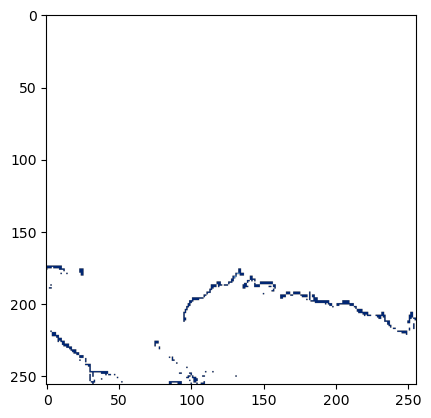

In [81]:
img1 = get_image(r'data\tiles\flood_0\x-0_y-1_z-3.png')
img2 = get_image(r'data\tiles\ssp1-2050\x-0_y-1_z-3.png')

def get_flooded_extent(flood_img,wms_img,save_dir=None):
    assert flood_img.shape[-1] == 4 and wms_img.shape[-1] == 4 #check that its img with alpha channel
    mask_list = [flood_img[:,:,-1],wms_img[:,:,-1]]
    mask_list = [(m/255).astype(np.uint8) for m in mask_list]
    flooded_extent_mask = np.multiply(*mask_list)
    flooded_extent_mask = np.repeat(flooded_extent_mask[:,:,np.newaxis],4,axis=2)
    # print(flooded_extent_mask.shape)
    flooded_extent = flooded_extent_mask*wms_img#[:,:,:3]
    if save_dir is not None:
        im = Image.fromarray(flooded_extent)
        im.save(f'{save_dir}.png')
    return flooded_extent

flooded_extent = get_flooded_extent(img1,img2)

plt.imshow(flooded_extent)

In [73]:
for i in range(1,6):
    for j in [2050,2100]:
        ssp_name = f'ssp{i}-{j}'
        save_tiles(mumbai_tiles,save_dir=r'data\mumbai_tiles',ssp_name=ssp_name)

data\mumbai_tiles\ssp1-2050\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp1-2050\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp1-2050\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp1-2050\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp1-2050\x-1439_y-912_z-11.png
data\mumbai_tiles\ssp1-2100\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp1-2100\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp1-2100\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp1-2100\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp1-2100\x-1439_y-912_z-11.png
data\mumbai_tiles\ssp2-2050\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp2-2050\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp2-2050\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp2-2050\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp2-2050\x-1439_y-912_z-11.png
data\mumbai_tiles\ssp2-2100\x-1438_y-913_z-11.png
data\mumbai_tiles\ssp2-2100\x-1438_y-914_z-11.png
data\mumbai_tiles\ssp2-2100\x-1439_y-913_z-11.png
data\mumbai_tiles\ssp2-2100\x-1438_y-912_z-11.png
data\mumbai_tiles\ssp2-2100\x-1439_y-912_z-11.png


In [ ]:
popn_2020 = [0,1,5,25,250,1000]

In [ ]:
def legend_cmap(legend,ssp_value,save_dir=None):
    legend_c = legend[45:365,7:20,:]
    breaks = len(ssp_value)
    color_range = np.linspace(0,legend_c.shape[0],breaks,dtype=int)
    color_list = []
    fig, axes = plt.subplots(breaks-1,1,figsize=(3,10))
    color_dict = dict()
    for i,ax in zip(range(len(color_range)-1),axes.flatten()):
        legend_slice = legend_c[color_range[i]:color_range[i+1],:,:]
        legend_slice = legend_slice[10:20,:,:]
        legend_slice_mean = np.mean(legend_slice,axis=(0,1)).astype(np.uint8)
        color_list.append(legend_slice_mean)
        ax.imshow(np.tile(legend_slice_mean.reshape(1,1,3),(10,10,1)))
        ax.axis('off')
        ax.set_title(f'{ssp_value[i]} - {ssp_value[i+1]-1}')
        color_dict[i] = {'pixel_val':legend_slice_mean,'min':ssp_value[i],'max':ssp_value[i+1]-1}
    plt.tight_layout()
    plt.show()

    if save_dir is not None:
        fig.savefig(f'{save_dir}.png')
        with open(f'{save_dir}.ob','wb') as f:
            pickle.dump(color_dict,f)
    
    return color_dict

# convert svg to png

In [8]:
import cairosvg
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

In [6]:
landuse_types = ['residential','slum','commercial','industrial']
for t in landuse_types:
    cairosvg.svg2png(
        url=os.path.join(r'data\landuse_png',f'{t}.svg'), write_to=os.path.join(r'data\landuse_png',f'{t}.png'))

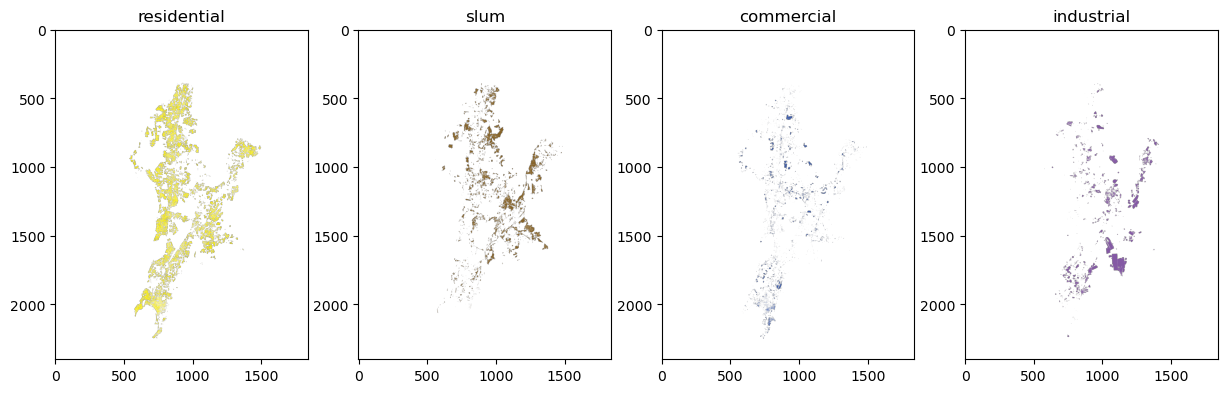

In [28]:
landuse_types = ['residential','slum','commercial','industrial']
weights = [2,2,1,1]
fig, axes = plt.subplots(1,len(landuse_types),figsize=(15,5))
landuse_weights = np.zeros((2400, 1840))
for i,t in enumerate(landuse_types):
    im = np.asarray(Image.open(os.path.join(r'data\landuse_png',f'{t}.png')))
    axes[i].imshow(im)
    axes[i].set_title(t)
    im_bin = np.where(im[:,:,-1]>0,weights[i],0)
    landuse_weights += im_bin
plt.show()

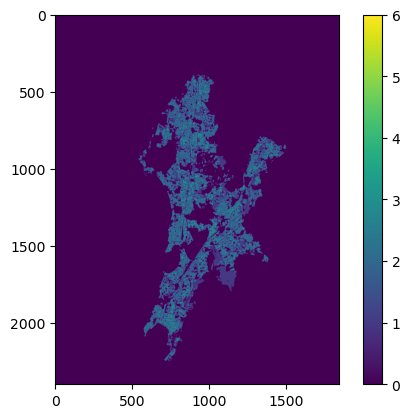

In [29]:
landuse_weights = np.asarray(Image.open(r'data\landuse_png\landuse_weights.png'))
plt.figure()
plt.imshow(landuse_weights)
plt.colorbar()
plt.show()
# im = Image.fromarray(landuse_weights.astype(np.uint8))
# im.save(os.path.join(r'data\landuse_png','landuse_weights.png'))

In [11]:
print(im.shape)
landuse = np.asarray(Image.open(r'layer/all.png'))
print(landuse.shape)

(2400, 1840, 4)
(1200, 920, 4)


In [9]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import cv2
import math
from scipy import ndimage
import os

# Land subsidence

In [35]:
ds = gdal.Open('mumbai_land_subsidence_clipped.tif', gdal.GA_ReadOnly)
ulx_subs, xres_subs, xskew_subs, uly_subs, yskew_subs, yres_subs  = ds.GetGeoTransform()
lrx_subs = ulx_subs + (ds.RasterXSize * xres_subs)
lry_subs = uly_subs + (ds.RasterYSize * yres_subs)
rb = ds.GetRasterBand(1)
land_subsidence = rb.ReadAsArray()
print(land_subsidence.shape)
UL_subs = (uly_subs,ulx_subs)
LR_subs = (lry_subs,lrx_subs)
print(UL_subs,LR_subs)
print(f'min: {land_subsidence.min()}, max: {land_subsidence.max()}')

(4246, 3485)
(19.31534, 72.775901) (18.89074, 73.124401)
min: -9.22546100616455, max: 5.134212493896484


# DEM

In [36]:
ds = gdal.Open('mumbai_dem_clipped.tif', gdal.GA_ReadOnly)
ulx_dem, xres_dem, xskew_dem, uly_dem, yskew_dem, yres_dem  = ds.GetGeoTransform()
lrx_dem = ulx_dem + (ds.RasterXSize * xres_dem)
lry_dem = uly_dem + (ds.RasterYSize * yres_dem)
rb = ds.GetRasterBand(1)
mumbai_dem = rb.ReadAsArray()
mumbai_dem[mumbai_dem == -99] = 0
print(f'min: {mumbai_dem.min()}, max: {mumbai_dem.max()}')
print(mumbai_dem.shape)
UL_dem = (uly_dem,ulx_dem)
LR_dem = (lry_dem,lrx_dem)
print(UL_dem,LR_dem)

min: -16.0, max: 489.0
(508, 417)
(19.314583333, 72.77625) (18.89125, 73.12375)


# Land use

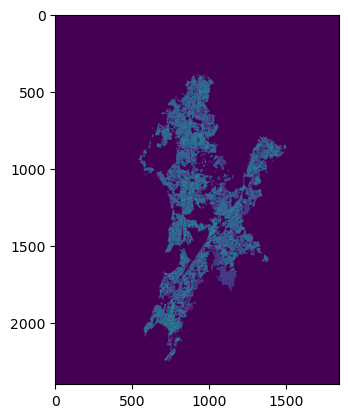

(2400, 1840)
(19.340018, 72.674303) (18.878474, 73.045951)
0.00020198260869565626 0.00019230999999999998
min: 0, max: 6


In [37]:
landuse = np.asarray(Image.open(r'data\landuse_png\landuse_weights.png'))
plt.figure()
plt.imshow(landuse)
plt.show()
print(landuse.shape)
lry_lu = 18.878474
ulx_lu = 72.674303
uly_lu = 19.3400180
lrx_lu = 73.045951

UL_lu = (uly_lu,ulx_lu)
LR_lu = (lry_lu, lrx_lu)
print(UL_lu,LR_lu)
yres_lu = (uly_lu - lry_lu)/landuse.shape[0]
xres_lu = (lrx_lu - ulx_lu)/landuse.shape[1]
print(xres_lu,yres_lu)
print(f'min: {landuse.min()}, max: {landuse.max()}')

# Population density

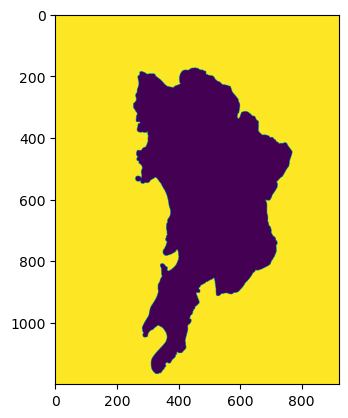

In [39]:
import os
# ward_boundary = np.asarray(Image.open(r'data\landuse_png\ward_boundary.png'))
# kernel = np.ones((5, 5), np.uint8)
# img_dilation = cv2.erode(ward_boundary[:,:,0], kernel, iterations=1)
# plt.figure()
# plt.imshow(img_dilation)
# plt.show()
# im = Image.fromarray(np.where(img_dilation>0,0,1))
# im.save(os.path.join(r'data\landuse_png','mumbai_outline.png'))

(1200, 920)
(1200, 920, 4)
1.0
1.0


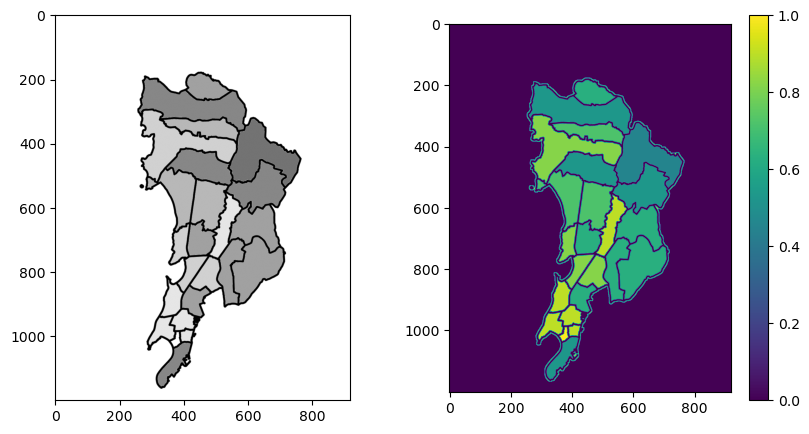

(19.340018, 72.674303) (18.878474, 73.045951)
0.0004039652173913125 0.00038461999999999996
min: 0.0, max: 1.0


In [38]:
popn_density = np.asarray(Image.open(r'data\landuse_png\popn_density.png'))
mumbai_outline = np.asarray(Image.open(r'data\landuse_png\mumbai_outline.png')).astype(np.float64)
popn_density = popn_density/popn_density.max()
popn_density_weights = popn_density[:,:,0]*mumbai_outline
print(mumbai_outline.shape)
print(popn_density.shape)
print(mumbai_outline.max())
print(popn_density.max())
# popn_density_weights = np.zeros(popn_density.shape,dtype=np.float64)
# popn_density_weights[:,:,3] = mumbai_outline
# popn_density_weights[:,:,:3] = popn_density[:,:,:3]

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(popn_density)
im = axes[1].imshow(popn_density_weights)
fig.colorbar(im, ax=axes[1])
plt.show()

lry_den = 18.878474
ulx_den = 72.674303
uly_den = 19.3400180
lrx_den = 73.045951

UL_den = (uly_den,ulx_den)
LR_den = (lry_den, lrx_den)
print(UL_den,LR_den)
yres_den = (uly_den - lry_den)/popn_density_weights.shape[0]
xres_den = (lrx_den - ulx_den)/popn_density_weights.shape[1]
print(xres_den,yres_den)
print(f'min: {popn_density_weights.min()}, max: {popn_density_weights.max()}')

# Ward boundary

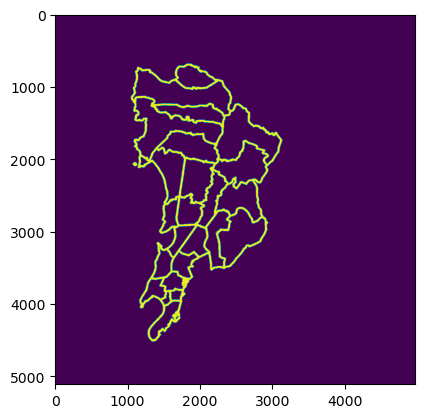

In [39]:
ward_boundary = np.asarray(Image.open(r'layer\ward_boundary.png'))[:,:,-1]

ward_boundary = cv2.resize(ward_boundary, (3770, 4660), interpolation = cv2.INTER_AREA)
ward_outline = np.zeros((5110, 4977))
ward_outline[0:4660, 0:3770] = ward_boundary
ward_outline = np.where(ward_outline>0,1,0)
plt.imshow(ward_outline)

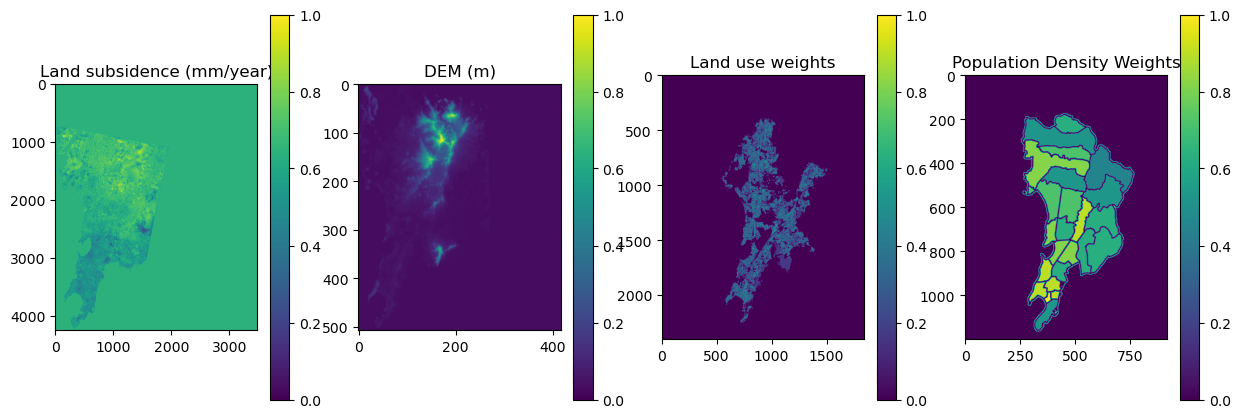

In [41]:
def normalise_img(im):
    max_im = im.max()
    min_im = im.min()
    return (im - min_im)/(max_im - min_im)

fig, axes = plt.subplots(1,4,figsize=(15,5))
im = axes[0].imshow(normalise_img(land_subsidence))
fig.colorbar(im, ax = axes[0])
axes[0].set_title('Land subsidence (mm/year)')
im = axes[1].imshow(normalise_img(mumbai_dem))
fig.colorbar(im, ax = axes[1])
axes[1].set_title('DEM (m)')
im = axes[2].imshow(normalise_img(landuse))
fig.colorbar(im, ax = axes[2])
axes[2].set_title('Land use weights')
im = axes[3].imshow(normalise_img(popn_density_weights))
fig.colorbar(im, ax = axes[3])
axes[3].set_title('Population Density Weights')
plt.show()

In [40]:
extents = {'land_subsidence':{'UL':UL_subs,'LR':LR_subs,'xres':xres_subs,'yres':yres_subs},
           'mumbai_dem':{'UL':UL_dem,'LR':LR_dem,'xres':xres_dem,'yres':yres_dem},
           'landuse': {'UL':(19.343, 72.672),'LR':LR_lu,'xres':xres_lu,'yres':yres_lu},
           'popn_density': {'UL':(19.343, 72.672),'LR':LR_den,'xres':xres_den,'yres':yres_den},
           'mask': {'UL':(19.343, 72.672),'LR':LR_den,'xres':xres_den,'yres':yres_den}
           }

extents

{'land_subsidence': {'UL': (19.31534, 72.775901),
  'LR': (18.89074, 73.124401),
  'xres': 0.0001000000000000004,
  'yres': -9.999999999999954e-05},
 'mumbai_dem': {'UL': (19.314583333, 72.77625),
  'LR': (18.89125, 73.12375),
  'xres': 0.0008333333333333251,
  'yres': -0.0008333333326771697},
 'landuse': {'UL': (19.343, 72.672),
  'LR': (18.878474, 73.045951),
  'xres': 0.00020198260869565626,
  'yres': 0.00019230999999999998},
 'popn_density': {'UL': (19.343, 72.672),
  'LR': (18.878474, 73.045951),
  'xres': 0.0004039652173913125,
  'yres': 0.00038461999999999996},
 'mask': {'UL': (19.343, 72.672),
  'LR': (18.878474, 73.045951),
  'xres': 0.0004039652173913125,
  'yres': 0.00038461999999999996}}

canvas shape: (5110, 4977)
img extent: (276, 4522, 1039, 4524)
img extent: (284, 4517, 1042, 4517)
img extent: (0, 4660, 0, 3770)
img extent: (0, 4660, 0, 3770)
img extent: (0, 4660, 0, 3770)
land_subsidence: min: 0.0 max: 1.0
landuse: min: 0.0 max: 1.0
mumbai_dem: min: 0.0 max: 1.0
popn_density: min: 0.0 max: 1.0
mask: min: 0.0 max: 1.0000000596046457


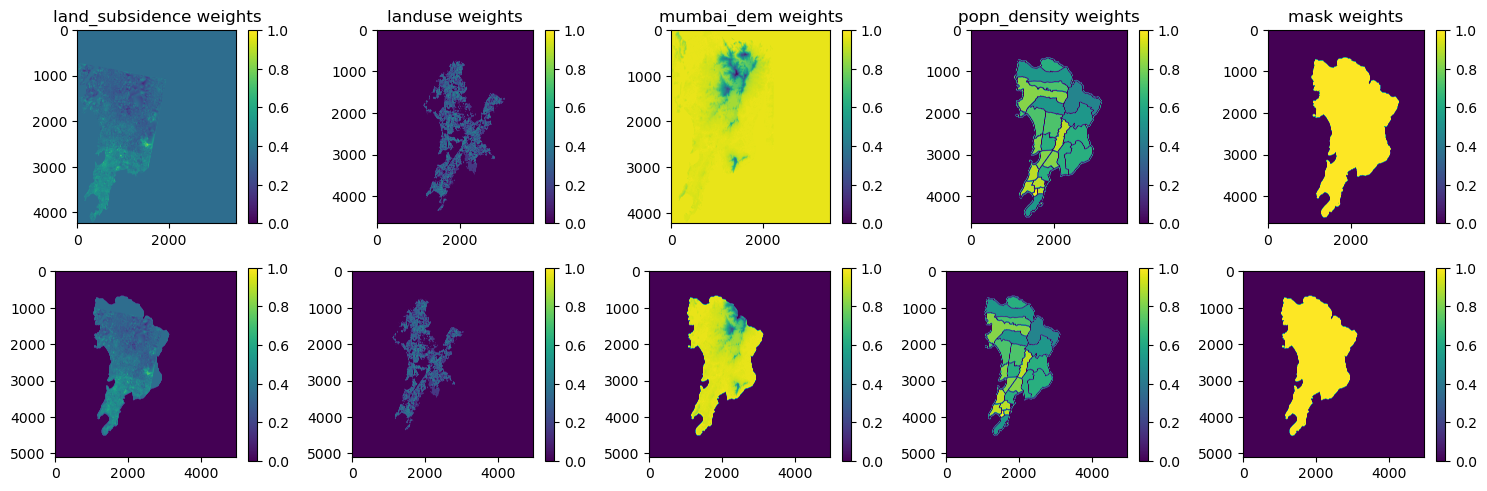

In [42]:
class VulnerabilityMap:
    def __init__(self,extents, img_subs, img_dem, img_lu, img_den, mask):
        """ 
        :param extents (dict): UL, LR, xres, yres
        :param img_subs (np.ndarray): land subsidence
        :param img_dem (np.ndarray): DEM
        :param img_lu (np.ndarray): land use weight
        :param mask (np.ndarray): outline mask of mumbai
        """
        self.extents = extents
        self.img_subs = img_subs
        self.img_dem = img_dem
        self.img_lu = img_lu
        self.img_den = img_den
        self.mask = mask
    
    def get_extent(self):
        max_lat_list = [d['UL'][0] for d in self.extents.values()]
        min_lat_list = [d['LR'][0] for d in self.extents.values()]
        max_lon_list = [d['LR'][1] for d in self.extents.values()]
        min_lon_list = [d['UL'][1] for d in self.extents.values()]
        max_lat = max(max_lat_list)
        min_lat = min(min_lat_list)
        max_lon = max(max_lon_list)
        min_lon = min(min_lon_list)
        UL = (max_lat, min_lon)
        LR = (min_lat, max_lon)
        return (UL, LR)
    
    def get_res(self):
        xres_list = [abs(d['xres']) for d in self.extents.values()]
        yres_list = [abs(d['yres']) for d in self.extents.values()]
        return min(xres_list), min(yres_list)
    
    def get_canvas(self,factor = 1.1):
        UL, LR = self.get_extent()
        xres, yres = self.get_res()
        nrows = int(math.ceil((UL[0] - LR[0])/yres)*factor)
        ncols = int(math.ceil((LR[1] - UL[1])/xres)*factor)
        canvas = np.zeros((nrows,ncols))
        canvas_extent = {'UL':UL,'LR':LR,'xres':xres,'yres':yres}
        print(f'canvas shape: {nrows,ncols}')
        return canvas, canvas_extent
    
    def get_lu_border(self):
        landuse_edge = ndimage.laplace(self.img_lu[:,:,-1])
        landuse_edge = np.where(landuse_edge<200,0.0,1.0)
        return landuse_edge
    
    def get_dem_border(self):
        dem_border = np.where(self.img_dem == -99,0,1)
        dem_border = ndimage.laplace(dem_border)
        return np.where(dem_border>0,1.0,0.0)
    
    def normalise_im(self, im):
        """ 
        outputs an image 0 - 1
        """
        im_copy = im.copy()
        im_copy = np.abs(im_copy)
        im_copy = im_copy/np.max(im_copy)
        return im_copy
    
    def normalise_img(self, im):
        max_im = im.max()
        min_im = im.min()
        return (im - min_im)/(max_im - min_im)

    def get_img_UL(self,im,canvas_extent, im_extent):
        nrow,ncol = im.shape[0], im.shape[1]
        top = int((canvas_extent['UL'][0] - im_extent['UL'][0])/canvas_extent['yres'])
        left = int((im_extent['UL'][1] - canvas_extent['UL'][1])/canvas_extent['xres'])
        bottom = top + nrow
        right = left + ncol
        return top, bottom, left, right
    
    def image_overlay(self, w_lu=3770, h_lu=4660, w_dem = 3475 ,h_dem = 4233):
        """ 
        check if image overlay properly
        """
        # img_lu_border = self.get_lu_border()
        # img_dem_border = self.get_dem_border()
        # resize images
        # img_lu_border = cv2.resize(img_lu_border, (w_lu,h_lu), interpolation = cv2.INTER_AREA)
        img_lu = cv2.resize(self.img_lu, (w_lu,h_lu), interpolation = cv2.INTER_AREA)
        img_den = cv2.resize(self.img_den, (w_lu,h_lu), interpolation = cv2.INTER_AREA)
        mask = cv2.resize(self.mask, (w_lu,h_lu), interpolation = cv2.INTER_AREA)
        img_dem = cv2.resize(self.img_dem, (w_dem,h_dem), interpolation = cv2.INTER_AREA)
        # get canvas
        canvas, canvas_extent = self.get_canvas()
        canvas_dict = dict()
        for k, extent in self.extents.items():
            canvas_copy = canvas.copy()
            if k == 'land_subsidence':
                im = self.normalise_img(self.img_subs)
                print(im.max(), im.min())
            elif k == 'mumbai_dem':
                im = self.normalise_img(img_dem)
                print(im.max(), im.min())
            elif k == 'landuse':
                im = self.normalise_img(img_lu)
                print(im.max(), im.min())
            elif k == 'popn_density':
                im = img_den
                print(im.max(), im.min())
            else:
                im = mask
                print(im.max(), im.min())
            top, bottom, left, right = self.get_img_UL(im, canvas_extent, extent)
            print(f'img extent: {top, bottom, left, right}')
            canvas_copy[top:bottom,left:right] = im
            canvas_dict[k] = canvas_copy
        
        for c in canvas_dict.values():
            canvas += c
        # canvas = canvas_dict['mumbai_dem'] + canvas_dict['popn_density']
        # plot
        plt.figure(figsize=(15,15))
        plt.imshow(canvas)
        plt.show()
        return
    
    def calculate_vulnerability_map(self, w_lu=3770, h_lu=4660, w_dem = 3475 ,h_dem = 4233,save=False):
        
        img_lu = cv2.resize(self.img_lu, (w_lu,h_lu), interpolation = cv2.INTER_AREA)
        img_dem = cv2.resize(self.img_dem, (w_dem,h_dem), interpolation = cv2.INTER_AREA)
        img_den = cv2.resize(self.img_den, (w_lu,h_lu), interpolation = cv2.INTER_AREA)
        mask = cv2.resize(self.mask, (w_lu,h_lu), interpolation = cv2.INTER_AREA)
        img_list = {'land_subsidence': self.img_subs,'landuse': img_lu,'mumbai_dem': img_dem,'popn_density': img_den}
        for k in list(img_list):
            img_list[k] = self.normalise_img(img_list[k])
        
        img_list['mask'] = mask
        for k in ['land_subsidence','mumbai_dem']:
            img_list[k] = np.ones(img_list[k].shape) - img_list[k] 
            #invert the weight values because smaller (-ve) land subsidence values means higher weight,
            # lower dem values means higher weight cus flooding vulnerability increases
        
        fig, axes = plt.subplots(2,len(list(img_list)), figsize=(15,5))
        for i,k in enumerate(list(img_list)):
            im = axes[0,i].imshow(img_list[k])
            axes[0,i].set_title(f'{k} weights')
            fig.colorbar(im,ax=axes[0,i])
        

        # get canvas
        canvas, canvas_extent = self.get_canvas()
        canvas_dict = dict()
        for k, extent in self.extents.items():
            canvas_copy = canvas.copy()
            im = img_list[k]
            top, bottom, left, right = self.get_img_UL(im, canvas_extent, extent)
            print(f'img extent: {top, bottom, left, right}')
            canvas_copy[top:bottom,left:right] = im
            canvas_dict[k] = canvas_copy

        # clip im by mask
        for i,k in enumerate(list(img_list)[:-1]):
            canvas_dict[k] = np.clip(canvas_dict[k]*canvas_dict['mask'],0,1)

        for i,k in enumerate(list(img_list)):
            print(f'{k}: min: {canvas_dict[k].min()} max: {canvas_dict[k].max()}')
            im = axes[1,i].imshow(canvas_dict[k])
            if save is True:
                im_int = canvas_dict[k]*255
                im_int = im_int.astype(np.uint8)
                im_save = Image.fromarray(im_int)
                im_save.save(os.path.join(r'data\vulnerability_map',f'{k}.png'))
            fig.colorbar(im,ax=axes[1,i])
        plt.tight_layout()
        plt.show()

        for c in list(canvas_dict)[:-1]:
            canvas += canvas_dict[c]
        
        return canvas


VM = VulnerabilityMap(extents, img_subs = land_subsidence, 
                      img_dem = mumbai_dem, 
                      img_lu = landuse, 
                      img_den = popn_density_weights, 
                      mask = mumbai_outline)
# VM.image_overlay()
vul_map = VM.calculate_vulnerability_map(save=False)

## import mask

(5110, 4977)
255


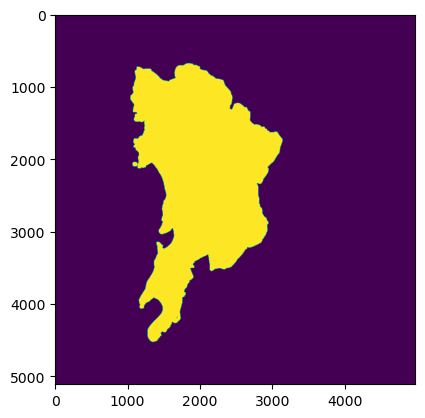

In [6]:
mask = np.asarray(Image.open(r'data\vulnerability_map\mask.png'))
print(mask.shape)
print(mask.max())
plt.imshow(mask)

# create new land use map

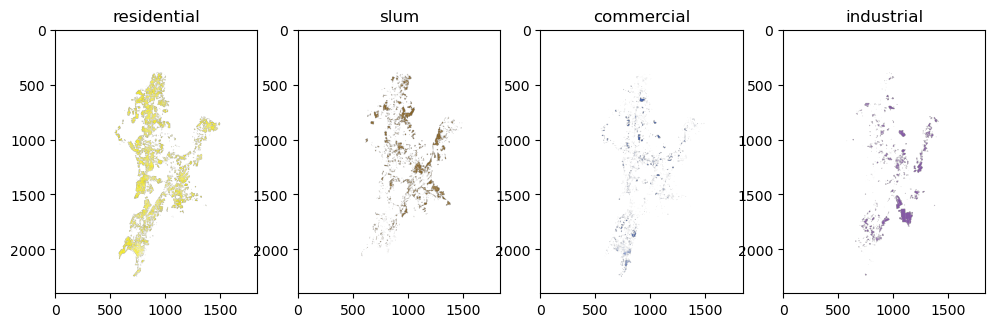

In [24]:
landuse_types = ['residential','slum','commercial','industrial']
fig, axes = plt.subplots(1,len(landuse_types), figsize=(12,5))
landuse_dict = dict()
for i,t in enumerate(landuse_types):
    fp = os.path.join(r'data\landuse_png',f'{t}.png')
    tmap = np.asarray(Image.open(fp))
    landuse_dict[t] = tmap
    axes[i].imshow(tmap)
    axes[i].set_title(t)
plt.show()

commercial = landuse_dict['commercial']
commercial_copy = commercial.copy()
for t in ['residential','slum','industrial']:
    idx = np.where(landuse_dict[t][:,:,-1] > 0)
    commercial_copy[idx[0],idx[1],:] = landuse_dict[t][idx[0],idx[1],:]

plt.imshow(commercial_copy)
im_save = Image.fromarray(commercial_copy)
im_save.save(os.path.join(r'data\vulnerability_map','landuse_simplified.png'))

## import vulnerability map

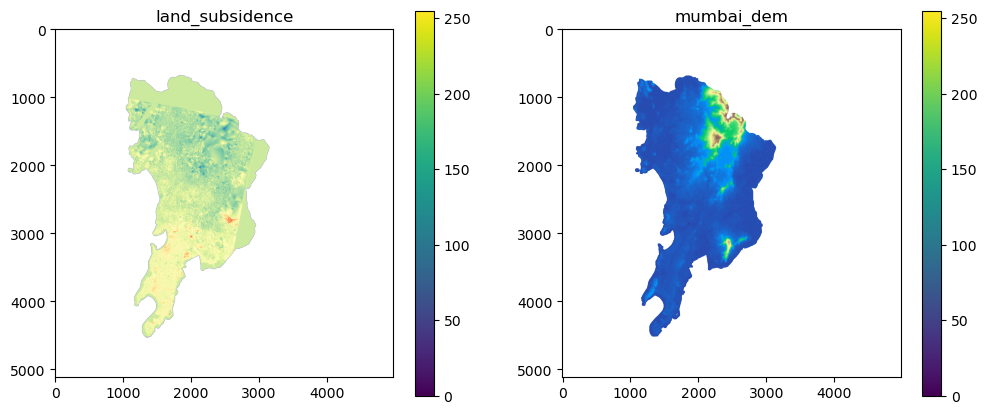

In [45]:
vul_maps = ['land_subsidence','mumbai_dem']
cmap_list = ['Spectral_r','terrain_r']
fig, axes = plt.subplots(1,len(vul_maps), figsize=(12,5))
vul_dict = dict()
for i,t in enumerate(vul_maps):
    fp = os.path.join(r'data\vulnerability_map',f'{t}_rgb.png')
    tmap = np.asarray(Image.open(fp))
    tmap_copy = tmap.copy()
    tmap_copy[:,:,-1] = mask
    vul_dict[t] = tmap_copy
    im = axes[i].imshow(tmap_copy)
    axes[i].set_title(t)
    fig.colorbar(im, ax = axes[i])
    # plt.imsave(os.path.join(r'data\vulnerability_map',f'{t}_rgb.png'),tmap,cmap=cmap_list[i])
plt.show()

In [50]:
for k, v in vul_dict.items():
    im_save = Image.fromarray(v)
    im_save.save(os.path.join(r'data\vulnerability_map',f'{k}_transparency.png'))

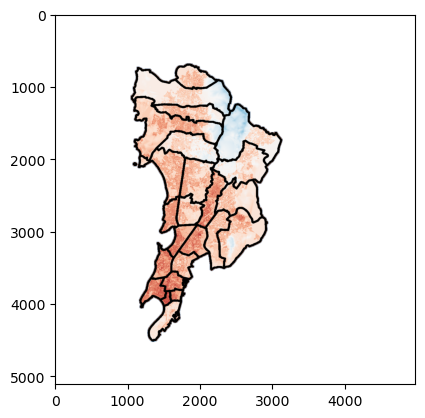

In [155]:
vul_map_rgb = np.asarray(Image.open(r'data\vulnerability_map\vulnerability_map.png'))

vul_map_rgb_copy = vul_map_rgb.copy()
# ward_outline1 = np.repeat(ward_outline[:,:,np.newaxis],4,axis=2)
vul_map_rgb_copy[:,:,-1] = mask
vul_map_rgb_copy[ward_outline == 1] = (0,0,0,255)
plt.imshow(vul_map_rgb_copy)

plt.imsave(os.path.join(r'data\vulnerability_map','vulnerability_map_transparency.png'),vul_map_rgb_copy)

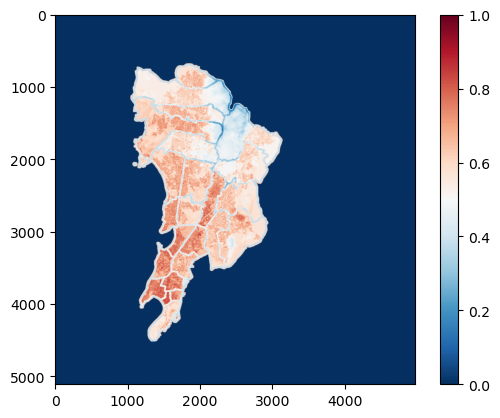

In [31]:
vul_map_rgb = np.asarray(Image.open(r'data\vulnerability_map\vulnerability_map.png'))
plt.figure()
plt.imshow(vul_map_rgb/vul_map_rgb.max(),cmap='RdBu_r')
plt.colorbar()
plt.show()

In [119]:
im = vul_map/vul_map.max()
plt.imsave(os.path.join(r'data\vulnerability_map','vulnerability_map.png'),im,cmap='RdBu_r')

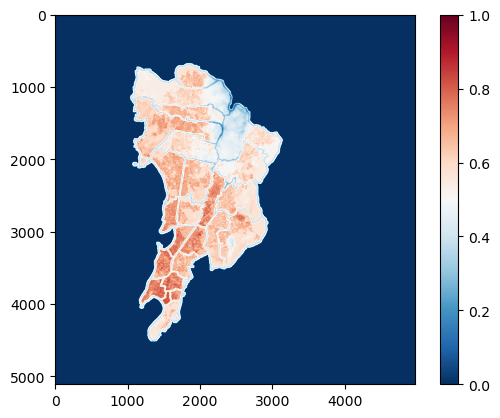

In [118]:

plt.figure()
plt.imshow(vul_map/vul_map.max(),cmap='RdBu_r')
plt.colorbar()
plt.show()